In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#Import the necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle

In [ ]:
#Set the seed value
SEED = 4243

資料來源:


*   https://www.kaggle.com/datasets/szelee/disasters-on-social-media/data
*   https://www.kaggle.com/code/hzy420/transformers-based-nlp-model-3-109c03




In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sample = pd.read_csv('/content/sample_submission.csv')
train2 = pd.read_csv('/content/socialmedia-disaster-tweets-DFE.csv')

# EDA of Original dataset
主要看資料空值的分布狀況，並以0補值

In [ ]:
#Define the label
TARGET = "target"

In [ ]:
#Define a function to plot he Null values in a given DataFrame
def plot_null_values(df):
    print("Total number of samples in the data =",df.shape[0])
    sns.heatmap(df.isnull().sum().to_frame(),
                annot=True,
                fmt="d",
                cmap="crest"
                )
    plt.title("Heatmap of NULL values")

				NULL values in Train Dataset
Total number of samples in the data = 7613


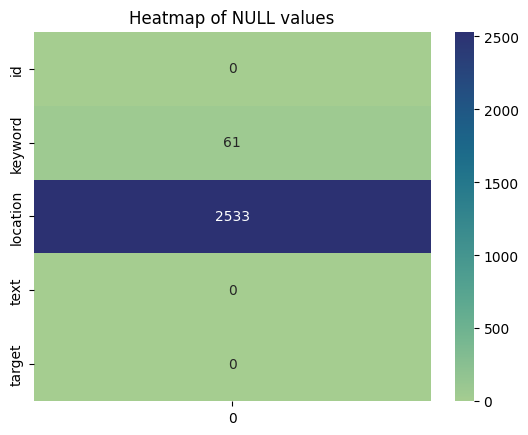

In [ ]:
#Use the plot_null_values function to plot Null values in the train dataset
print("\t\t\t\tNULL values in Train Dataset")
plot_null_values(train)

				NULL values in Test Dataset
Total number of samples in the data = 3263


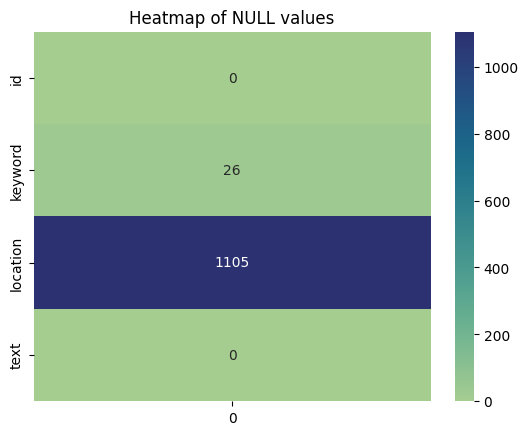

In [ ]:
#Use the plot_null_values function to plot Null values in the test dataset
print("\t\t\t\tNULL values in Test Dataset")
plot_null_values(test)

In [ ]:
#Replace the Null values with str(0)
train.fillna("0",inplace=True)
test.fillna("0",inplace=True)

				NULL values in Train Dataset
Total number of samples in the data = 7613


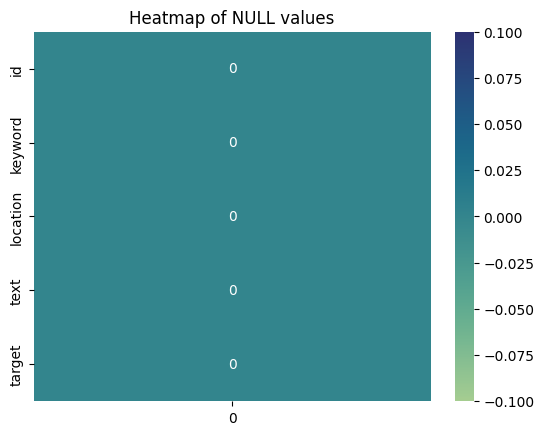

In [ ]:
#Check the updated train dataset
print("\t\t\t\tNULL values in Train Dataset")
plot_null_values(train)

				NULL values in Test Dataset
Total number of samples in the data = 3263


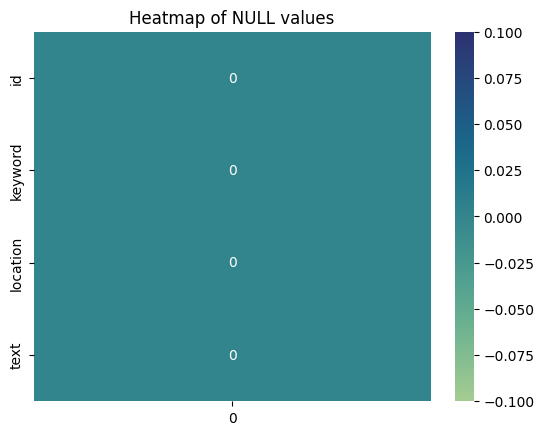

In [ ]:
#Check the updated test dataset
print("\t\t\t\tNULL values in Test Dataset")
plot_null_values(test)

In [ ]:
#Check for duplicate values
train[train.duplicated()]

,id,keyword,location,text,target


# target analysis
To assess the balance of our data, let's examine the distribution of values in the "target" column.

Text(0.5, 1.0, 'Distribution of target values')

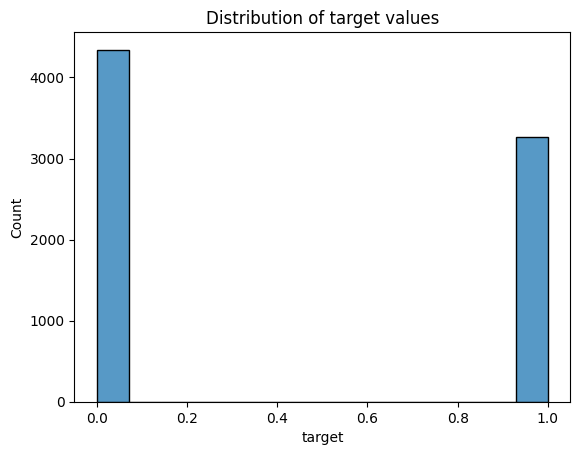

In [ ]:
#Target analysis
sns.histplot(x=train[TARGET])
plt.title("Distribution of target values")

Feature Analysis
Let's examine the distribution of features.


*   fatalities(死亡人數)
*   armageddon(世界末日)
*   deluge(洪水)
*   harm(傷害)
*   damage(傷害）
*   sinking(下沈）



In [ ]:
#Group the train DataFrame by "keyword" column and
# count the "target" Series group values
keyword = train.groupby("keyword")["target"].count()

#Convert the above Groupby Object to DataFrame and sort the values
keyword_df = pd.DataFrame(data={"keyword":keyword.index, "count":keyword.values}).sort_values(by=["count"],ascending=False)
keyword_df

,keyword,count
0,0,61
105,fatalities,45
9,armageddon,42
64,deluge,42
120,harm,41
...,...,...
116,forest%20fire,19
95,epicentre,12
195,threat,11
135,inundation,10


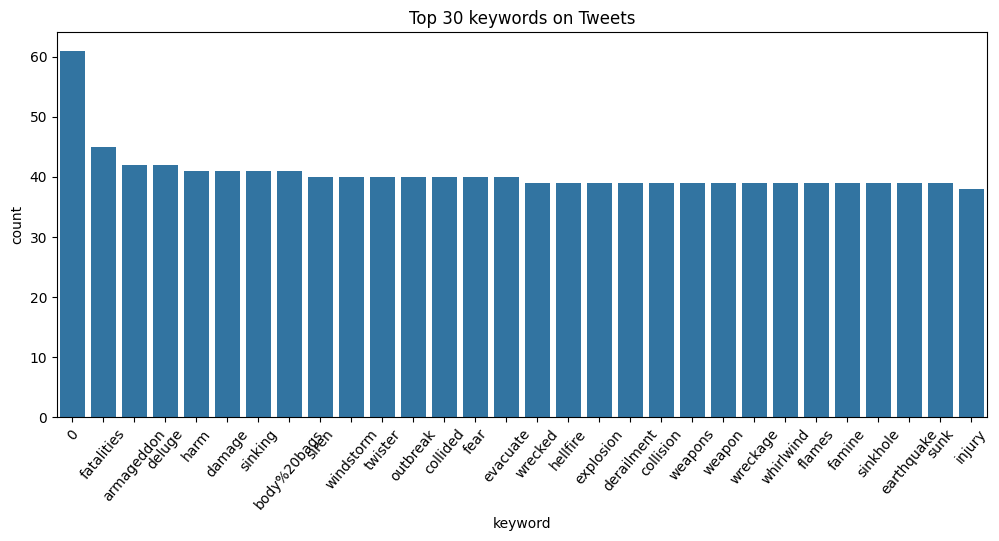

In [ ]:
#Let's plot the "key" DataFrame
plt.figure(figsize=(12,5))
#Limit the data to top 30 keywords by .head() method
sns.barplot(data=keyword_df.head(30), x = 'keyword',y = 'count')
plt.xticks(rotation = 50)
plt.ylabel('count')
plt.title('Top 30 keywords on Tweets');

In [ ]:
#Group the train DataFrame by "keyword" column and
# count the "target" Series group values
location = train.groupby("location")["target"].count()

#Convert the above Groupby Object to DataFrame and sort the values
location_df = pd.DataFrame(data={"location":location.index, "count":location.values}).sort_values(by=["count"],ascending=False)
location_df

,location,count
80,0,2533
2644,USA,104
1827,New York,71
2663,United States,50
1507,London,45
...,...,...
1199,Hueco Mundo,1
1200,"Hughes, AR",1
1201,"Huntington, WV",1
1202,"Huntley, IL",1


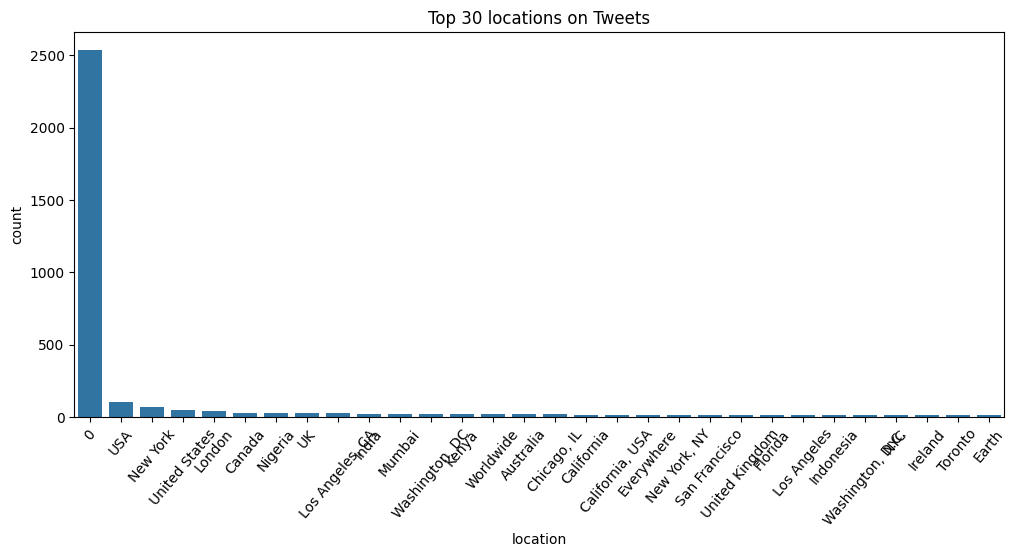

In [ ]:
#Let's plot the "location" DataFrame
plt.figure(figsize=(12,5))

#Limit the data to top 30 locations by .head() method
sns.barplot(data=location_df.head(30), x = 'location',y = 'count')
plt.xticks(rotation = 50)
plt.ylabel('count')
plt.title('Top 30 locations on Tweets');

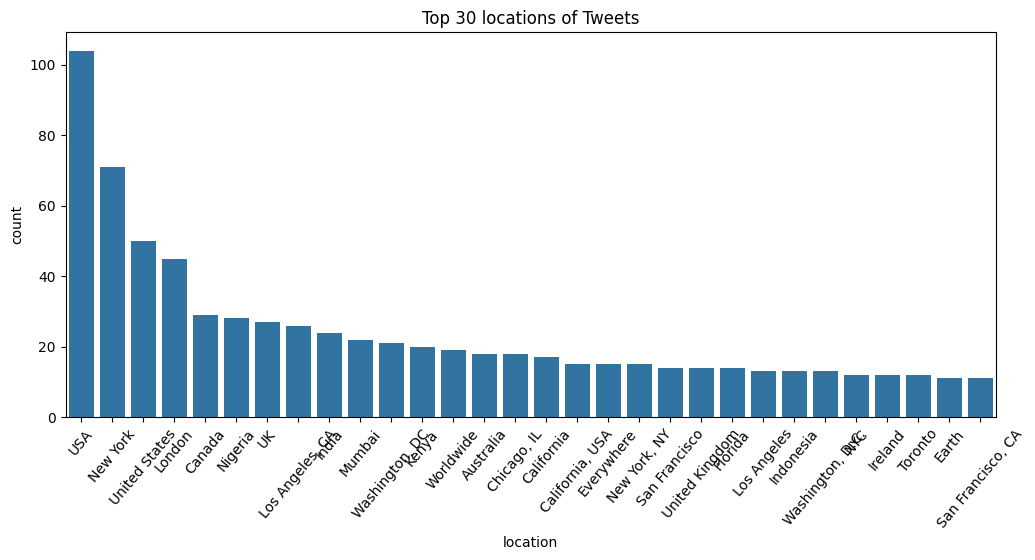

In [ ]:
#Let's plot the "location" DataFrame with "0" discarded
plt.figure(figsize=(12,5))

#Limit the data to top 30 locations by .head() method
# and use the iloc to discard "0"
sns.barplot(data=location_df.head(31).iloc[1:,:], x = 'location',y = 'count')
plt.xticks(rotation = 50)
plt.ylabel('count')
plt.title('Top 30 locations of Tweets');

In [ ]:
#Define a function to get the maximum length of words in each column
def check_max_length_sentence(df):
    max_length = 0
    for text in df["text"]:
        if len(text) > max_length:
            max_length = len(text)
    print("Maximum length of Text column is:",max_length)

    max_length = 0
    for text in df["location"]:
        if len(text) > max_length:
            max_length = len(text)
    print("Maximum length of Location column is:",max_length)

    max_length = 0
    for text in df["keyword"]:
        if len(text) > max_length:
            max_length = len(text)
    print("Maximum length of Keyword column is:",max_length)

In [ ]:
#Maximum lengths of columns in train data
check_max_length_sentence(train)
#Maximum lengths of columns in test data
check_max_length_sentence(test)

Maximum length of Text column is: 157
Maximum length of Location column is: 49
Maximum length of Keyword column is: 21
Maximum length of Text column is: 151
Maximum length of Location column is: 42
Maximum length of Keyword column is: 21


In [ ]:
#推文長度的分布
def get_sentence_lengths(df):
    df2 = pd.DataFrame(columns=["length"])
    i = 0
    for text in df["text"]:
        df2.loc[i,"length"] = len(text)
        i+=1
    return df2

def plot_sentence_lengths(df):
    lengths_df = get_sentence_lengths(df)
    bins = range(0,161,20)
    plt.hist(lengths_df["length"], bins=bins,alpha=0.3)
    #sns.countplot(data=lengths_df, x="length")
    plt.title("Distribution of sentence lengths")

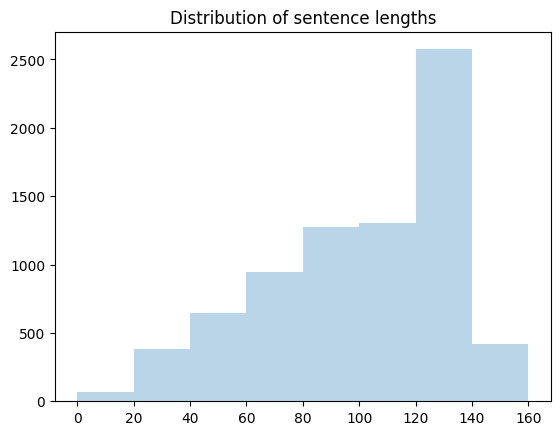

In [ ]:
#Use the plot_sentence_lengths function on train dataset
plot_sentence_lengths(train)

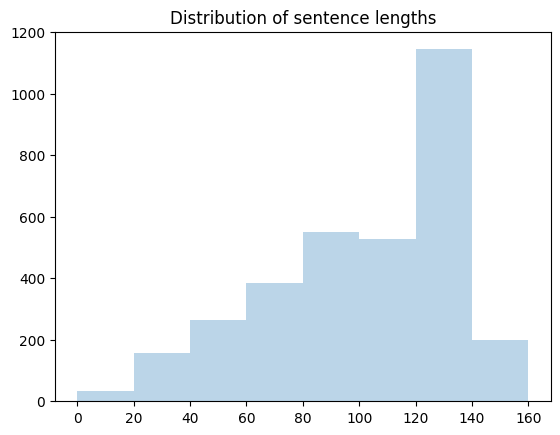

In [ ]:
#Use the plot_sentence_lengths function on test dataset
plot_sentence_lengths(test)

# Analyze the Disaster on Social Media dataset

In [ ]:
#Extract the part relevant columns
train2s = train2[["keyword","location","text","choose_one"]].copy()
train2s

,keyword,location,text,choose_one
0,NaN,NaN,Just happened a terrible car crash,Relevant
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Relevant
2,NaN,NaN,"Heard about #earthquake is different cities, s...",Relevant
3,NaN,NaN,"there is a forest fire at spot pond, geese are...",Relevant
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Relevant
...,...,...,...,...
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Relevant
10872,NaN,NaN,Police investigating after an e-bike collided ...,Relevant
10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,Relevant
10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant


In [ ]:
#Check for the Null values
train2s.isnull().sum()

keyword         87
location      3638
text             0
choose_one       0
dtype: int64

Total number of samples in the data = 10876


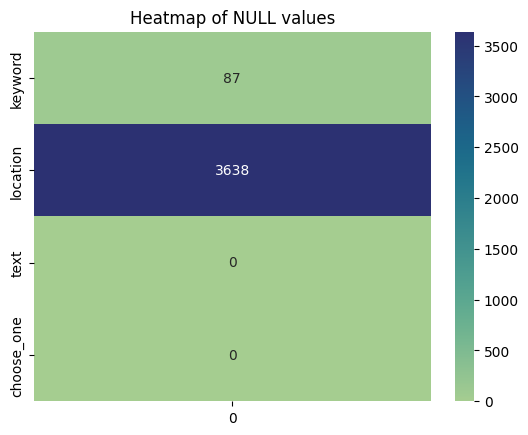

In [ ]:
#For a better understanding, let's see the plot of Null values
plot_null_values(train2s)

Total number of samples in the data = 10876


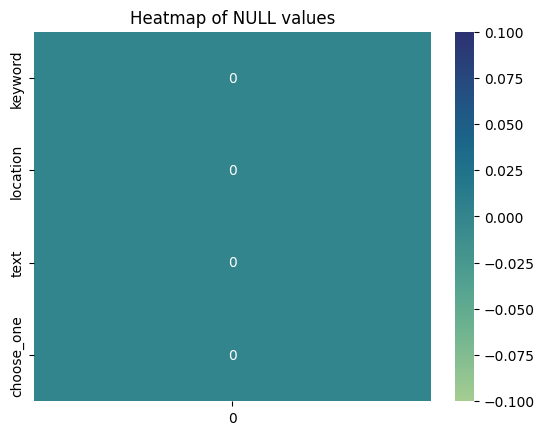

In [ ]:
#Fill the Null values with str(0)
train2s.fillna("0",inplace=True)

#Check for te Null values
plot_null_values(train2s)

# Target Analysis of Disaster on Social Media dataset

In [ ]:
#Renname the "choose_one" column as "text"
train2s.rename(columns={"choose_one":"target"},inplace=True)
train2s.head()

,keyword,location,text,target
0,0,0,Just happened a terrible car crash,Relevant
1,0,0,Our Deeds are the Reason of this #earthquake M...,Relevant
2,0,0,"Heard about #earthquake is different cities, s...",Relevant
3,0,0,"there is a forest fire at spot pond, geese are...",Relevant
4,0,0,Forest fire near La Ronge Sask. Canada,Relevant


In [ ]:
#Unique values in the target column
train2s["target"].unique()

array(['Relevant', 'Not Relevant', "Can't Decide"], dtype=object)

In [ ]:
#Count the unique values in the target column
target_count = train2s["target"].value_counts()
target_count_df = pd.DataFrame(data={"target_category":target_count.index, "count":target_count.values})
target_count_df

,target_category,count
0,Not Relevant,6187
1,Relevant,4673
2,Can't Decide,16


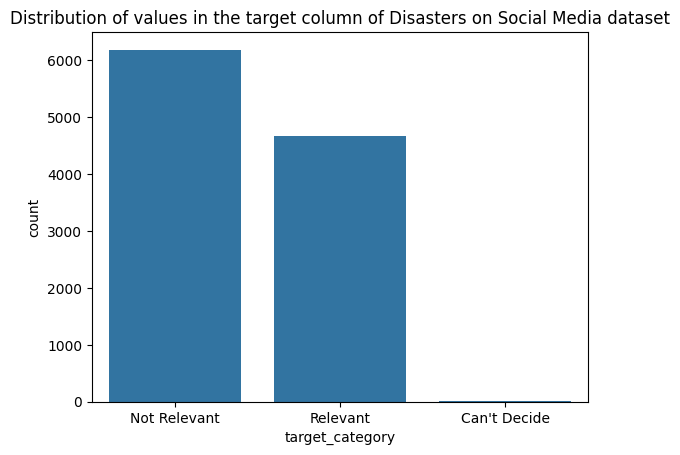

In [ ]:
#Plot the values count of target column
sns.barplot(data=target_count_df,x="target_category", y="count")
plt.title("Distribution of values in the target column of Disasters on Social Media dataset");

In [ ]:
#Let's convert the categorical values of target column to integer
train2s["target"] = (train2s["target"] == "Relevant").astype("int")
train2s.head()

,keyword,location,text,target
0,0,0,Just happened a terrible car crash,1
1,0,0,Our Deeds are the Reason of this #earthquake M...,1
2,0,0,"Heard about #earthquake is different cities, s...",1
3,0,0,"there is a forest fire at spot pond, geese are...",1
4,0,0,Forest fire near La Ronge Sask. Canada,1


In [ ]:
#Count the unique values in the target column
df = train2s["target"].value_counts()
df = pd.DataFrame({"target_value":df.index, "count":df.values})

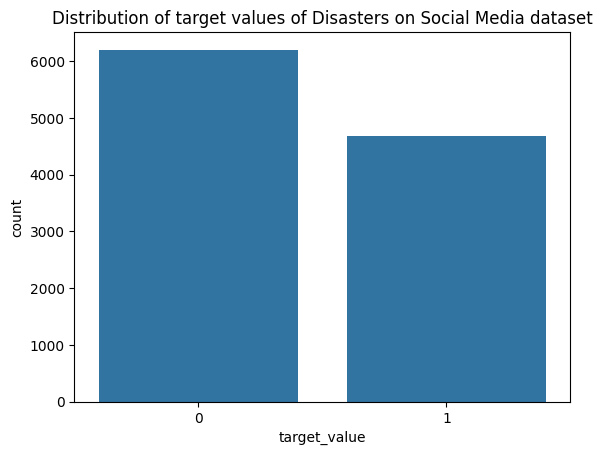

In [ ]:
#Plot the values count of target column
sns.barplot(data=df, x="target_value", y="count")
plt.title("Distribution of target values of Disasters on Social Media dataset");

# data processing

In [ ]:
#Remove the "id" column form the train DataFrame
train.pop("id")

0           1
1           4
2           5
3           6
4           7
        ...  
7608    10869
7609    10870
7610    10871
7611    10872
7612    10873
Name: id, Length: 7613, dtype: int64

In [ ]:
#Combine the two datasets
train_dataset = pd.concat([train, train2s])
train_dataset.head()

,keyword,location,text,target
0,0,0,Our Deeds are the Reason of this #earthquake M...,1
1,0,0,Forest fire near La Ronge Sask. Canada,1
2,0,0,All residents asked to 'shelter in place' are ...,1
3,0,0,"13,000 people receive #wildfires evacuation or...",1
4,0,0,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#Shape of the combined dataset
train_dataset.shape

(18489, 4)

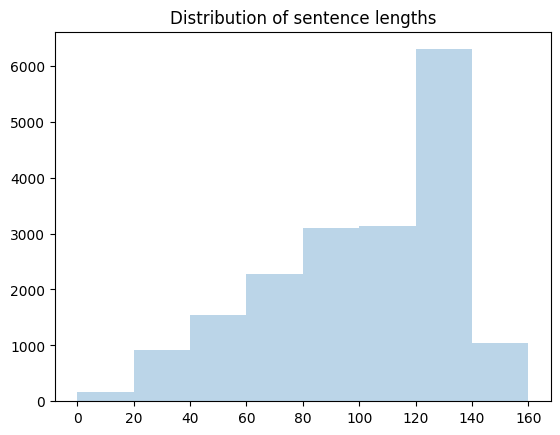

In [ ]:
#Use the plot_sentence_lengths to check the distribution og tweet lengths
plot_sentence_lengths(train_dataset)

In [ ]:
#Shuffle the DataFrame
train_dataset = shuffle(train_dataset, random_state=SEED)
train_dataset = shuffle(train_dataset, random_state=int(SEED/2))
train_dataset.head()

,keyword,location,text,target
3046,death,0,@Kaay_Paat it's actually death and takes way l...,0
10789,wrecked,Pennsylvania,Four hundred wrecked cars (costing $100 apiece...,0
467,attack,Online 24/7. Not even kidding.,Notley's tactful yet very direct response to H...,1
7480,wreck,0,Ranking #artectura #pop2015 #Nå¼36 Florence + ...,0
6772,lightning,"Greensboro, North Carolina",Heavy rain gusty winds and vivid lightning mov...,1


In [ ]:
train_dataset['keyword']

3046               death
10789            wrecked
467               attack
7480               wreck
6772           lightning
              ...       
8484            screamed
10173    violent%20storm
3670            fatality
5612            flooding
459               attack
Name: keyword, Length: 18489, dtype: object

In [ ]:
#Convert train data to tf.data.Dataset object
BATCH = 32
#Concatenate the text data of the columns "keyword", "location", "text"
train_tf = tf.data.Dataset.from_tensor_slices(
    (train_dataset['keyword'] + train_dataset['location'] + train_dataset['text'], train_dataset[TARGET]))

#Convert the data into batch
train_tf = train_tf.shuffle(int((SEED*13)/8)).batch(BATCH)

#Convert test data to tf.data.Dataset object
test_tf = tf.data.Dataset.from_tensor_slices(test['keyword'] + test['location'] + test['text'])

#Convert the data into batch
test_tf = test_tf.batch(BATCH)

In [ ]:
max_length = 165
max_tokens = 20_000

#Instantiate the TextVectorization layer
text_vectorization = layers.TextVectorization(max_tokens=max_tokens,
                                              output_mode='int',
                                              output_sequence_length=max_length
                                             )

In [ ]:
#Learn the vocabulary
text_vectorization.adapt(train_tf.map(lambda twt, target: twt))

In [ ]:
#Get the vocabulary
vocab = text_vectorization.get_vocabulary()
print("Vocabulary size =",len(vocab))

#Convert the list object to NumPy array for decoding the vectorized data
vocab = np.array(vocab)

Vocabulary size = 20000


In [ ]:
#Get the vocabulary
vocab = text_vectorization.get_vocabulary()
print("Vocabulary size =",len(vocab))

#Convert the list object to NumPy array for decoding the vectorized data
vocab = np.array(vocab)

Vocabulary size = 20000


In [ ]:
#Vectorize the train dataset
train_tf = train_tf.map(lambda twt, target: (text_vectorization(twt), target),
                   num_parallel_calls=tf.data.AUTOTUNE)

#Vectorize the test dataset
test_tf = test_tf.map(lambda twt: text_vectorization(twt),
                      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
#Define a function to print the tokenized data
def print_sample(data_obj):
    for sample, traget in data_obj:
        #Print the first item
        print("1st sample:",sample[0].numpy())
        print("\n")
        #Print the second item
        print("2nd sample:",sample[1].numpy())
        print("\n")
        #Print the third item
        print("3rd sample:",sample[2].numpy())
        print("\n")
        break

In [ ]:
#Print the tokenized data
print_sample(train_tf)

1st sample: [   1  909   67    5  426    2 1364   58   76   46  805  116 4032   32
   16  498   30   16    2 1091  465 2028    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


2nd sample: [16236     1   155   283  1363     5    12    16     2   304  4956     1
     0     0     0     0     0     0     0     0     0     0   

In [ ]:
#Print the vectorized tweet and the decoded tweet
for tx in train_tf:
    print("\t\t\t\tVectorized Tweet:\n",tx[0][0])
    print("\n\n\t\t\t\tDecoded Tweet:\n", " ".join(vocab[tx[0][0].numpy()]))
    break

				Vectorized Tweet:
 tf.Tensor(
[13353  3233  3604    14     2  1069     5  8716  3238 13603     4   884
    29     2  3787     6   423 16488     1     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     

# model

In [ ]:
#Define a Transformer Encoder using subclassed layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        #Size of the input vector (size of the vocabulary)
        self.embed_dim = embed_dim
        #Size of the inner dense layer
        self.dense_dim = dense_dim
        #Number of attention heads
        self.num_heads = num_heads

        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
                   [layers.Dense(dense_dim, activation="relu"),
                    layers.Dense(embed_dim),]
                                        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.max_pool1 = layers.GlobalMaxPooling1D()

    #Define a call() method  where forward pass is implemented
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        #Apply the attention layer
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        #Normalize the data
        proj_input = self.layernorm_1(inputs + attention_output)
        #Apply the dense layer
        proj_output = self.dense_proj(proj_input)
        #Normalize the data and return it
        return self.layernorm_2(proj_input + proj_output)

        #return self.max_pool1(norm)

    #Define configuration method
    def get_config(self):
        config = super().get_config()
        config.update({
                    "embed_dim": self.embed_dim,
                    "num_heads": self.num_heads,
                    "dense_dim": self.dense_dim,
                    })
        return config

In [ ]:
# Implementing positional embedding as a subclassed layer
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.token_embeddings = layers.Embedding(
          input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
                   input_dim=sequence_length, output_dim=output_dim)

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
            return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
           "output_dim": self.output_dim,
           "sequence_length": self.sequence_length,
           "input_dim": self.input_dim,
                    })
        return config

In [ ]:
#Construct the model

#Define the input
inputs = keras.Input(shape=(None,), dtype="int64")

#Apply positional embeddings
pos_embed = PositionalEmbedding(sequence_length=165,
                        input_dim=20_000,
                        output_dim=256)(inputs)

#Apply the encoder
encoded = TransformerEncoder(embed_dim=256,
                             dense_dim=32,
                             num_heads=8)(pos_embed)


x = layers.GlobalMaxPooling1D()(encoded) #
x = layers.Dropout(0.5)(x)
output = layers.Dense(units=1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs,outputs=output)

In [ ]:
#Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.98,epsilon=1e-9),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )

In [ ]:
#Summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posi  (None, None, 256)         5162240   
 tionalEmbedding)                                                
                                                                 
 transformer_encoder (Trans  (None, None, 256)         2121248   
 formerEncoder)                                                  
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

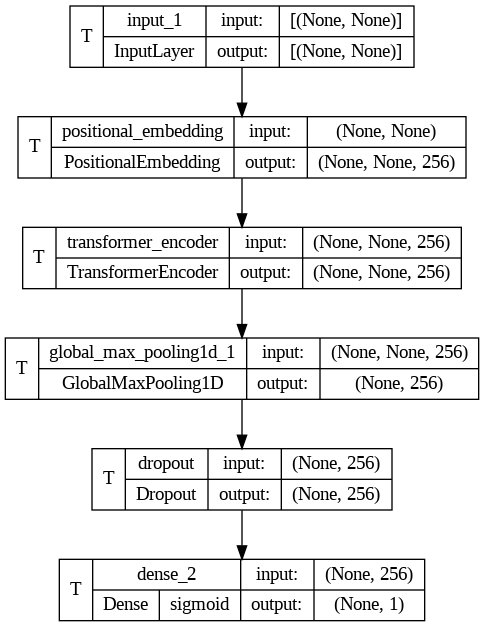

In [ ]:
#Plot the model
keras.utils.plot_model(model=model,
                       to_file="model.png",
                       show_shapes=True,
                       show_layer_names=True,
                       expand_nested=True,
                       show_layer_activations=True,
                       show_trainable=True,
        )

In [ ]:
#Define callbacks
callbacks = [
       keras.callbacks.ModelCheckpoint("tweets_classifier.keras",
                                       save_best_only=True)
            ]

In [ ]:
#Define the validation data size
val_size = int(0.25 * len(train_tf))

In [ ]:
# Split the data into training and validation
validation_data = train_tf.take(val_size)
train_data = train_tf.skip(val_size)

In [ ]:
#Train the model
history = model.fit(train_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/10
434/434 [==============================] - 36s 66ms/step - loss: 1.2049 - accuracy: 0.5228 - val_loss: 0.6641 - val_accuracy: 0.6018
Epoch 2/10
434/434 [==============================] - 22s 51ms/step - loss: 0.9677 - accuracy: 0.5490 - val_loss: 0.6320 - val_accuracy: 0.6359
Epoch 3/10
434/434 [==============================] - 21s 49ms/step - loss: 0.7811 - accuracy: 0.5868 - val_loss: 0.5903 - val_accuracy: 0.7033
Epoch 4/10
434/434 [==============================] - 22s 50ms/step - loss: 0.6844 - accuracy: 0.6294 - val_loss: 0.5449 - val_accuracy: 0.7498
Epoch 5/10
434/434 [==============================] - 22s 51ms/step - loss: 0.6132 - accuracy: 0.6791 - val_loss: 0.5023 - val_accuracy: 0.7760
Epoch 6/10
434/434 [==============================] - 22s 50ms/step - loss: 0.5548 - accuracy: 0.7219 - val_loss: 0.4695 - val_accuracy: 0.7856
Epoch 7/10
434/434 [==============================] - 22s 51ms/step - loss: 0.4938 - accuracy: 0.7669 - val_loss: 0.4452 - val_accuracy:

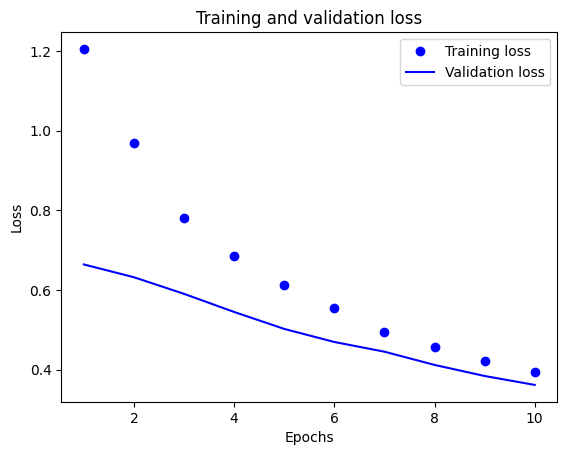

In [ ]:
# Plotting the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

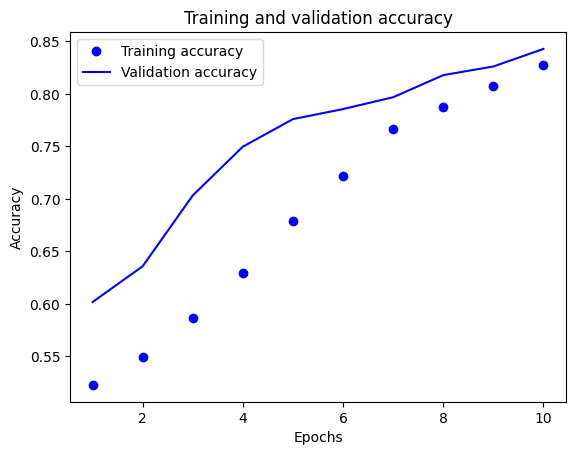

In [ ]:
# Plotting the training and validation accuracy
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
#Classify the tweets of test data
predictions = model.predict(test_tf)

102/102 [==============================] - 2s 18ms/step


In [ ]:
#Print the predictions
predictions

array([[0.6644159 ],
       [0.30549636],
       [0.5430436 ],
       ...,
       [0.9479899 ],
       [0.96065503],
       [0.40173116]], dtype=float32)

In [ ]:
threshold = 0.5
#Convert the float values to binary
final_predictions = [1 if i > threshold else 0 for i in predictions]
final_predictions[:10]

[1, 0, 1, 1, 1, 1, 0, 0, 0, 0]

In [ ]:
sample

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [ ]:
submissions = pd.DataFrame(columns=["id","target"])
submissions["target"] = final_predictions
submissions["id"] = test.id
submissions

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
#Save the file as a csv file
submissions.to_csv("submission.csv", index=False)